# Introduction

#SWDchallenge: visualize THIS data!
MARCH 01, 2019 BY COLE NUSSBAUMER KNAFLIC
UPDATE: It seems we may have overcomplicated things this time around. Let’s simplify!

You can download the file with country-to-country donations here. Create a visual to ANSWER ONE QUESTION: WHO DONATES? (Related subquestions you may also answer: How are donations distributed across countries?
* Who donates to whom? Are there any patterns, for example some group of countries tends to donate only to some specific group of other countries?)
*  How are donations distributed across countries?

* SHARE: Tweet your graph(s) or post publicly and email the link to SWDchallenge@storytellingwithdata.com.

NEW EXTENDED DEADLINE: Friday, March 15th (midnight PST). 

You’re of course welcome to do more (original full instructions follow), but our hopes are that simplifying will boost participation and we’ll get enough content to push some important data viz research forward!

In [170]:
import pandas as pd
from pathlib import Path
import qgrid
import altair as alt

In [171]:
DATA = Path('data')

In [172]:
df = pd.read_csv(DATA/'aiddata-countries-only.csv',index_col=0)

In [173]:
grid = qgrid.show_grid(df)

In [174]:
grid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Who donates to whom? Are there any patterns, for example some group of countries tends to donate only to some specific group of other countries?)

* Sankey Diagram

## How are donations distributed across countries?
* Bar Chart
* Map
* Treemap

In [176]:
# alt.renderers.enable('notebook')

In [178]:
df.head()

,aiddata_id,aiddata_2_id,year,donor,recipient,commitment_amount_usd_constant,coalesced_purpose_code,coalesced_purpose_name
1,2414478.0,NaN,1977,Saudi Arabia,India,348718518.0,23030,Power generation/renewable sources
2,2414509.0,NaN,1977,Saudi Arabia,Brazil,191647004.0,23040,Electrical transmission/ distribution
3,2414635.0,NaN,1983,Saudi Arabia,India,79371799.0,21030,Rail transport
4,2414665.0,NaN,1984,Saudi Arabia,Taiwan,212202942.0,21030,Rail transport
5,2414667.0,NaN,1984,Saudi Arabia,Korea,134511154.0,21040,Water transport


In [179]:
from altair import X,Y,Color, Order, EncodingSortField
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# Top Donor

In [206]:
brush = alt.selection(type='interval', encodings=['y'])
sort=alt.EncodingSortField(
            field="commitment_amount_usd_constant",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )

In [207]:
tmp = df[['donor','commitment_amount_usd_constant']].groupby(['donor']).sum().reset_index()


In [246]:
chart_donor_group = (alt.Chart(tmp)
 .mark_bar()
 .encode(y=Y('donor:N', sort=sort,title=''),
         x=X('sum(commitment_amount_usd_constant):Q', title='Amount'),
         tooltip=['sum(commitment_amount_usd_constant)'],
         color=alt.condition(brush, alt.value('#1696d2'), alt.value('lightgray'))
).transform_window(
    rank='rank(commitment_amount_usd_constant)',
    sort=[alt.SortField('commitment_amount_usd_constant', order='descending')]
).transform_filter(
    (alt.datum.rank < 10)
).add_selection(brush)
              )

chart_donor_group.title = 'Top 10 Donors'


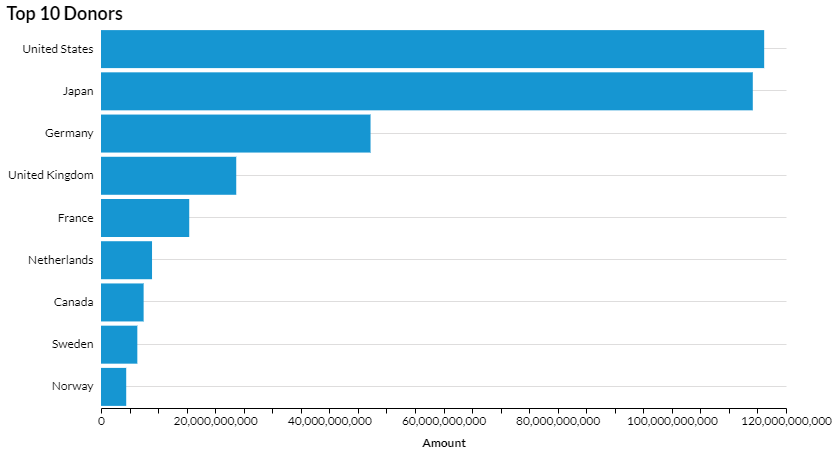

In [247]:
chart_donor_group

# Stack Graph

In [183]:
df_stack = df[['donor','commitment_amount_usd_constant']].copy()
df_stack.loc[~df_stack['donor'].isin(['United States','Japan','Germany','United Kingdom']), 'donor'] = 'Others'
df_stack = df_stack.groupby(['donor']).sum().reset_index()
df_stack.head()

,donor,commitment_amount_usd_constant
0,Germany,4.721844e+10
1,Japan,1.141823e+11
2,Others,6.553658e+10
3,United Kingdom,2.369054e+10
4,United States,1.161763e+11


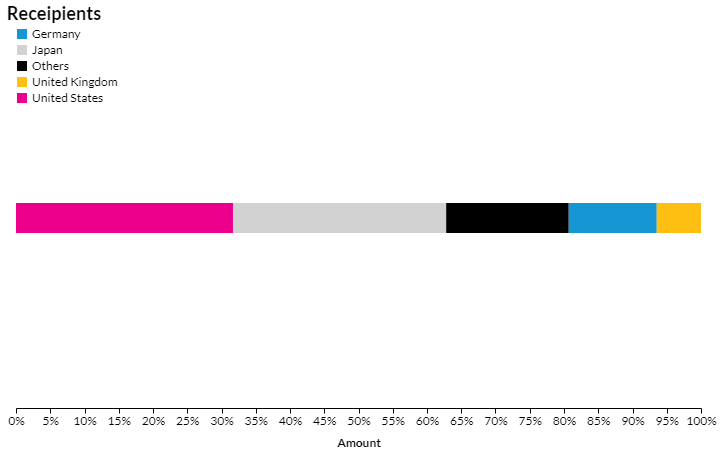

In [249]:
chart_stack = (alt.Chart(df_stack)
 .mark_bar()
 .encode(
         x=X('sum(commitment_amount_usd_constant):Q',sort=sort, title='Amount',stack='normalize',axis=alt.Axis(format='.0%')),
         tooltip=['commitment_amount_usd_constant'],
                 color='donor:N',
     order=alt.Order(
      # Sort the segments of the bars by this field
      'commitment_amount_usd_constant',
      sort='descending')
)
              )

chart_stack.title = 'Receipients'


chart_stack 

# Top Recipent

In [251]:
chart_recipient = (alt.Chart(df)
 .mark_bar()
 .encode(y=Y('recipient:N', sort=sort, title=''),
         x=X('sum(commitment_amount_usd_constant):Q', title='Amount')
).transform_filter(brush))

chart_recipient.title='Receipients'

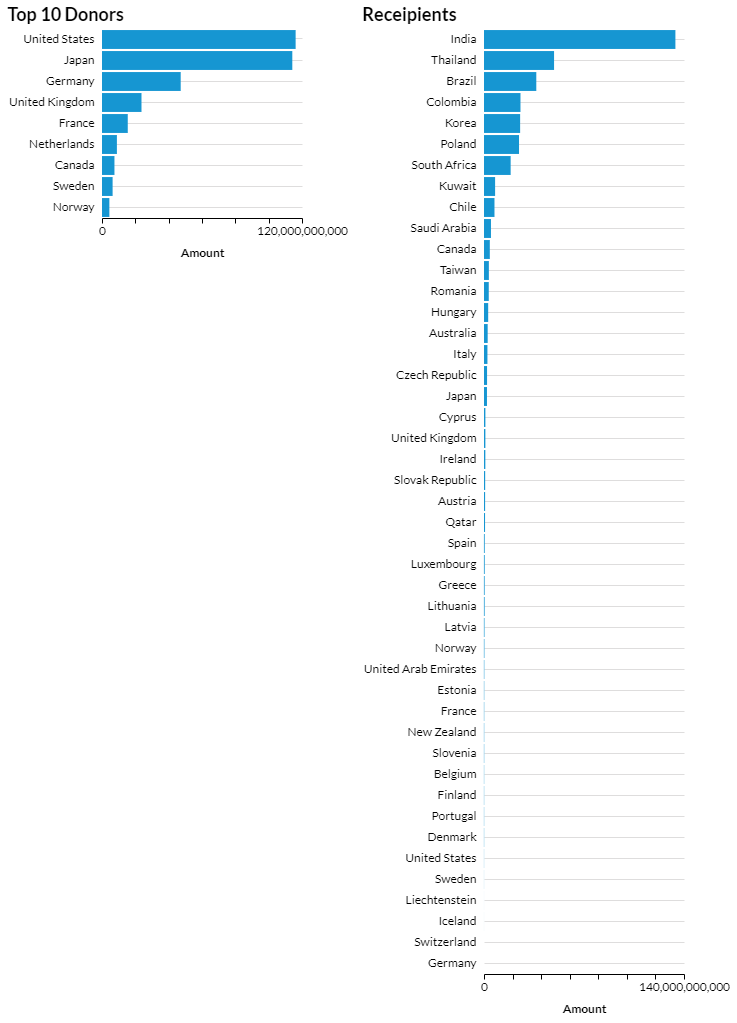

In [252]:
final_chart = chart_donor_group | chart_recipient
final_chart.save('datachallenge.html')
final_chart

# TODO
* Cross-filter to show overall percentage
* trellis of line graph

# Cross Filter (Not Finished)

In [67]:
brush = alt.selection(type='interval', encodings=['x'])

# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart().mark_bar().encode(
    x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=20)),
    y='count()'
).properties(
    width=180,
    height=130
)

# blue background with selection
background = base.properties(selection=brush)

# yellow highlights on the transformed data
highlight = base.encode(
    color=alt.value('goldenrod')
).transform_filter(brush)

# layer the two charts & repeat
alt.layer(
    background,
    highlight,
    data=source
).transform_calculate(
    "time",
    "hours(datum.date)"
).repeat(column=["distance", "delay", "time"])

NameError: name 'source' is not defined

# Ref

In [99]:
df.columns

Index(['aiddata_id', 'aiddata_2_id', 'year', 'donor', 'recipient',
       'commitment_amount_usd_constant', 'coalesced_purpose_code',
       'coalesced_purpose_name'],
      dtype='object')

In [102]:
tmp = df[['donor', 'recipient','commitment_amount_usd_constant']].groupby(['donor', 'recipient']).sum().reset_index()
tmp.to_csv(DATA/'output.csv',index=False)

In [103]:
tmp

,donor,recipient,commitment_amount_usd_constant
0,Australia,Brazil,1.084346e+07
1,Australia,Chile,1.151201e+07
2,Australia,Colombia,1.056582e+07
3,Australia,Cyprus,1.872882e+07
4,Australia,Czech Republic,6.918000e+03
5,Australia,Hungary,9.846550e+05
6,Australia,India,9.820759e+08
7,Australia,Korea,7.599604e+06
8,Australia,Poland,3.046000e+03
9,Australia,Saudi Arabia,7.575000e+03


In [212]:
def urban_theme():
    markColor = "#1696d2"
    axisColor = "#000000"
    backgroundColor = "#FFFFFF"
    font = "Lato"
    labelFont = "Lato"
    sourceFont = "Lato"
    gridColor = "#DEDDDD"
    main_palette = ["#1696d2", 
                    "#d2d2d2",
                    "#000000", 
                    "#fdbf11", 
                    "#ec008b", 
                    "#55b748", 
                    "#5c5859", 
                    "#db2b27", 
                   ]
    sequential_palette = ["#cfe8f3", 
                          "#a2d4ec", 
                          "#73bfe2", 
                          "#46abdb", 
                          "#1696d2", 
                          "#12719e", 
                         ]
    return {
        "width": 685,
        "height": 380,   
#        "autosize": "fit",
        "config": {
            "title": {
                "anchor": "start",
                "fontSize": 18,
                "font": font,
                "fontColor": "#000000"
            },
            "axisX": {
               "domain": True,
               "domainColor": axisColor,
               "domainWidth": 1,
               "grid": False,
               "labelFontSize": 12,
               "labelFont": labelFont,
               "labelAngle": 0,
               "tickColor": axisColor,
               "tickSize": 5,
               "titleFontSize": 12,
               "titlePadding": 10,
               "titleFont": font,
               "title": "",
           },
           "axisY": {
               "domain": False,
               "grid": True,
               "gridColor": gridColor,
               "gridWidth": 1,
               "labelFontSize": 12,
               "labelFont": labelFont,
               "labelPadding": 8,
               "ticks": False,
               "titleFontSize": 12,
               "titlePadding": 10,
               "titleFont": font,
               "titleAngle": 0,
               "titleY": -10,
               "titleX": 18,
           },
           "background": backgroundColor,
           "legend": {
               "labelFontSize": 12,
               "labelFont": labelFont,
               "symbolSize": 100,
               "symbolType": "square",
               "titleFontSize": 12,
               "titlePadding": 10,
               "titleFont": font,
               "title": "",
               "orient": "top-left",
               "offset": 0,
           },
           "view": {
               "stroke": "transparent",
           },
           "range": {
               "category": main_palette,
               "diverging": sequential_palette,
           },
           "area": {
               "fill": markColor,
           },
           "line": {
               "color": markColor,
               "stroke": markColor,
               "strokewidth": 5,
           },
           "trail": {
               "color": markColor,
               "stroke": markColor,
               "strokeWidth": 0,
               "size": 1,
           },
           "path": {
               "stroke": markColor,
               "strokeWidth": 0.5,
           },
           "point": {
               "filled": True,
           },
           "text": {
               "font": sourceFont,
               "color": markColor,
               "fontSize": 11,
               "align": "right",
               "fontWeight": 400,
               "size": 11,
           }, 
           "bar": {
                "size": 40,
                "binSpacing": 1,
                "continuousBandSize": 30,
                "discreteBandSize": 30,
                "fill": markColor,
                "stroke": False,
            }, 
       },
    }
    
    
import altair as alt
alt.themes.register("my_custom_theme", urban_theme)
alt.themes.enable("my_custom_theme")

ThemeRegistry.enable('my_custom_theme')